In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [11]:
df=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',dtype='unicode')# code to convert the csv file into dataframe object in python
columns_from_main=['location','date','new_cases','total_vaccinations',"population"]#these are the columns that we will be considering
print ("This is original data frame: \n",df)

This is original data frame: 
        iso_code continent     location        date total_cases new_cases  \
0           AFG      Asia  Afghanistan  2020-02-24         5.0       5.0   
1           AFG      Asia  Afghanistan  2020-02-25         5.0       0.0   
2           AFG      Asia  Afghanistan  2020-02-26         5.0       0.0   
3           AFG      Asia  Afghanistan  2020-02-27         5.0       0.0   
4           AFG      Asia  Afghanistan  2020-02-28         5.0       0.0   
...         ...       ...          ...         ...         ...       ...   
135576      ZWE    Africa     Zimbabwe  2021-11-20    133615.0      22.0   
135577      ZWE    Africa     Zimbabwe  2021-11-21    133647.0      32.0   
135578      ZWE    Africa     Zimbabwe  2021-11-22    133674.0      27.0   
135579      ZWE    Africa     Zimbabwe  2021-11-23    133674.0       0.0   
135580      ZWE    Africa     Zimbabwe  2021-11-24    133747.0      73.0   

       new_cases_smoothed total_deaths new_deaths new_de

# Filtering the data



<p>1) Recent 180 days data <br>
    2) Selecting countries' data <br>
3) Removing all the rows with NaN values and negative values</p>

In [12]:
#the following 2 lines help filter out the last 180 dyas preceding 8th of november 2021
df['date']=pd.to_datetime(df['date'])
mask=(df['date']>='5/13/2021')&(df['date']<='11/8/2021')
df_location=df.loc[(mask)&(df['location']=='Japan'),columns_from_main]


#the following 3 lines of code help drop all the NaN values from the specified columns
df_location.dropna(subset=['total_vaccinations'],inplace=True)#drops NaN from total_vaccinations column
df_location.dropna(subset=['population'],inplace=True)#drops NaN from population column
df_location.dropna(subset=['new_cases'],inplace=True)#drops NaN from new_cases column

#convert the string value to a number:
df_location["new_cases"]=pd.to_numeric(df_location["new_cases"], downcast='integer')
df_location['total_vaccinations']=pd.to_numeric(df_location['total_vaccinations'], downcast='integer')
df_location['population']=pd.to_numeric(df_location['population'], downcast='integer')
print(df_location.dtypes)

#This is to filter out the data from countries such that the new_cases and the total_vaccinations is greater than 0 
mask2=(df_location["new_cases"] > 0)&(df_location['total_vaccinations'] > 0)
df_location=df_location.loc[mask2,columns_from_main]

print(df_location.size)
print("The locations under observation are:\n",df_location)


location                      object
date                  datetime64[ns]
new_cases                      int16
total_vaccinations             int32
population                     int32
dtype: object
720
The locations under observation are:
       location       date  new_cases  total_vaccinations  population
62104    Japan 2021-05-13       6874             6695597   126050796
62105    Japan 2021-05-14       6262             7116487   126050796
62106    Japan 2021-05-15       6417             7287316   126050796
62107    Japan 2021-05-16       5256             7495054   126050796
62108    Japan 2021-05-17       3677             8102078   126050796
...        ...        ...        ...                 ...         ...
62276    Japan 2021-11-01         84           190022071   126050796
62278    Japan 2021-11-03        264           190595761   126050796
62279    Japan 2021-11-04        158           191044946   126050796
62282    Japan 2021-11-07        157           192078918   126050796


# Collections of Functions

In [13]:
#this function helps create two separate dataframes for each: target and feature
def get_features_targets(df, feature_names, target_names):
    df_feature=df[feature_names]
    df_target=df[target_names]
    return df_feature, df_target

#Helps normalize the data 
def normalize_z(df):
    return (df-df.mean())/df.std()

#converts the features data frame into a numpy array and then converts it into a column vector and adds a column of 1s at the beggining
def prepare_feature(df_feature):
    df_feature=df_feature.to_numpy()
    c_ones=np.ones((df_feature.shape[0],1))
    df_feature=np.hstack((c_ones,df_feature))
    return df_feature

#converts the targets data frame into a numpy array
def prepare_target(df_target):
    df_target=df_target.to_numpy()
    return df_target

#normalizes the features using z normalization 
def predict(df_feature, beta):
    X=prepare_feature(normalize_z(df_feature))
    return predict_norm(X,beta)

#helps calculate the straight line equation after standardization
def predict_norm(X, beta):
    return np.matmul(X,beta)

#splits the data into training set and testing set. The default standard to split the data set is to slice it in half
def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indexes=df_feature.index
    if random_state!=None:
        np.random.seed(random_state)
    num_rows = len(indexes)
    k = int(test_size * num_rows)
    test_indices = np.random.choice(indexes, k, replace = False)
    train_indices = set(indexes) - set(test_indices)
    
    df_feature_train = df_feature.loc[train_indices, :]
    df_feature_test = df_feature.loc[test_indices, :]
    df_target_train = df_target.loc[train_indices, :]
    df_target_test = df_target.loc[test_indices, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

#function to calculate the coefficient of determination
def r2_score(y, ypred):
    actual_mean = np.mean(y)
    # since y, ypred are both nparray, y-ypred does element wise SUB
    ssres = np.sum((y-ypred)**2)
    sstot = np.sum((y-actual_mean)**2)
    return 1 - (ssres/sstot)

#function to calculate the mean squared error
def mean_squared_error(target, pred):
    num_of_samples = target.shape[0] # number of samples == number of rows in target_y
    return (1/num_of_samples) * np.sum((target-pred)**2)

#function to calculate the gradient descent
def gradient_descent(X, y, beta, alpha, num_iters):
    # For linreg, X is a n by 2 matrix, beta is a 2 by 1 vector, y (actual_target) n by 1 vector, alpha is Float, num_iters is an Int
    # beta -> initial guess of beta 
    ### BEGIN SOLUTION
    number_of_samples = X.shape[0]
    J_storage = np.zeros((num_iters, 1))
    # iterate the grad desc until num_iters
    # or, until convergence (other case)
    for i in range(num_iters):
        # this derivate is derived from the squared error function 
        # STEP 2
        # Y_pred = X x Beta
        # diff Y_pred/Beta --> X.T x (X x Beta) 
        # transpose X and put on the left hand side of matrix mul
        derivative_cost_wrt_Beta = (1/number_of_samples) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # update beta
        # STEP 3
        beta = beta - alpha * derivative_cost_wrt_Beta
        J_storage[i] = compute_cost(X, y, beta)
    ### END SOLUTION
    return beta, J_storage

#function to calculate the cost function
def compute_cost(X, y, beta):
    # for LinReg: X is n by 2, y is a vector of n elements, beta is 2 by 1
    J = 0
    ### BEGIN SOLUTION
    number_of_samples = X.shape[0]
    # Y_pred - Y_actual
    # Y_pred = Xb
    Y_pred = np.matmul(X, beta)
    diff_between_pred_actual_y = Y_pred - y
    diff_between_pred_actual_y_sq = np.matmul(diff_between_pred_actual_y.T, diff_between_pred_actual_y)
    J = (1/(2*number_of_samples)) * diff_between_pred_actual_y_sq
    ### END SOLUTION
    # J is an error, it is a scalar, so extract the only element of J that was a numpy array
    return J[0][0]

#returns the log value 
def logarithm(df_target, target_name):
    ### BEGIN SOLUTION
    df_out = df_target.copy()
    df_out.loc[:, target_name] = df_target[target_name].apply(lambda x: math.log(x))
    ### END SOLUTION
    return df_out

# Splitting data
### Target: 
#### $$new\_cases$$
### Feature: 
#### $$\frac{total\_vaccinations}{total\_population}$$

Beta1 is equal to 5393.958866010651
Beta2 is equal to 560.7813009836627


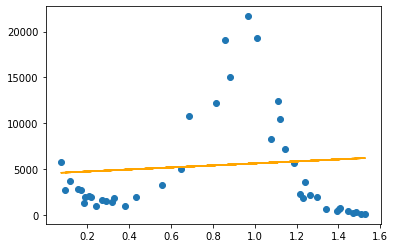

In [14]:
#this line creates a new column called total_vaccinations
df_location.loc[:,"total_vaccinations/population"] = df_location['total_vaccinations'].div(df_location['population'])
features=['total_vaccinations/population']
target=['new_cases']
df_features,df_target=get_features_targets(df_location,features,target)

#calls the split_data split the data into training set and testing set
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features,df_target,random_state=100,test_size=0.3)
df_features_train_z=normalize_z(df_features_train)

X=prepare_feature(df_features_train_z)
target=prepare_target(df_target_train)

iterations=1500
alpha=0.01
beta=np.zeros((2,1))

#calls the gradient descent function and stores the value of the slope and the intercept in a variable called beta
beta,J_storage=gradient_descent(X,target,beta,alpha,iterations)
#to calculate the predicted value
pred=predict(df_features_test,beta)
print("Beta1 is equal to",beta[0][0])
print("Beta2 is equal to",beta[1][0])
plt.scatter(df_features_test, df_target_test)
plt.plot(df_features_test, pred, color="orange")

## R2 Coefficient of Determination and Mean Squared Error

In [15]:
#converting the target into a numpy array and storing it inside a variable called the_target
the_target = prepare_target(df_target_test)
#to calculate the coefficient of deteremination
r2= r2_score(the_target, pred)
print("Coefficient of Determination:",r2)
#to calculate the mean_squared error
mse = mean_squared_error(the_target, pred)
print("Mean Squared Error:",mse)

Coefficient of Determination: -0.018703407496614588
Mean Squared Error: 31785544.419363298


# Improvement
#### Using $$lnY$$ instead of $$Y$$ and applying a limited data range for $$(x>0.8)$$


Beta0 and beta1 is equal to: 
[[ 7.95685278]
 [-0.38173742]]
R2 Coefficient of Determination:
0.04207476395799015
Mean Squared Error:
1.7358226166143007
Beta1 is equal to 7.956852780847363
Beta2 is equal to -0.38173742309552106


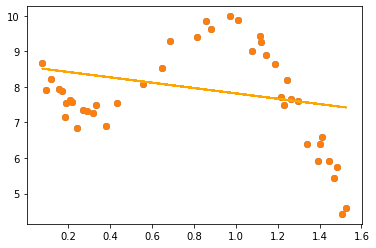

In [16]:
#re-preforming the process carried out in the previous step given the above improvement

df_location.loc[:,"total_vaccinations/population"] = df_location['total_vaccinations'].div(df_location['population'])
features=['total_vaccinations/population']
target=['new_cases']
df_features,df_target=get_features_targets(df_location,features,target)
# Try to set the range for x


if df_location['location'].all()=='Japan':
    df_features_improved = df_features.loc[df_features["total_vaccinations/population"]>0.8]
else:
    df_features_improved = df_features
df_target_improved = df_target.loc[set(df_features_improved.index),:]
#print(df_features_improved)
#myplot = sns.scatterplot(x="total_vaccinations/population", y="new_cases", data=df_location)
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_improved,df_target_improved,random_state=100,test_size=0.3)
df_features_train_z=normalize_z(df_features_train)
#Apply logrithm to change y to lny

df_target_train = logarithm(df_target_train, "new_cases")
df_target_test = logarithm(df_target_test, "new_cases")

X=prepare_feature(df_features_train_z)
Y=prepare_target(df_target_train)
#print(df_target_test)
iterations=1500
alpha=0.01

df_location.loc[:,"total_vaccinations/population"] = df_location['total_vaccinations'].div(df_location['population'])
features=['total_vaccinations/population']
target=['new_cases']
df_features,df_target=get_features_targets(df_location,features,target)
# Try to set the range for x


if df_location['location'].all()=='Japan':
    df_features_improved = df_features.loc[df_features["total_vaccinations/population"]>0.8]
else:
    df_features_improved = df_features
df_target_improved = df_target.loc[set(df_features_improved.index),:]
#print(df_features_improved)
#myplot = sns.scatterplot(x="total_vaccinations/population", y="new_cases", data=df_location)
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_improved,df_target_improved,random_state=100,test_size=0.3)
df_features_train_z=normalize_z(df_features_train)
#Apply logarithm to change y to lny

df_target_train = logarithm(df_target_train, "new_cases")
df_target_test = logarithm(df_target_test, "new_cases")

X=prepare_feature(df_features_train_z)
Y=prepare_target(df_target_train)
#print(df_target_test)
iterations=1500
alpha=0.01
beta=np.zeros((2,1))

beta,J_storage=gradient_descent(X,Y,beta,alpha,iterations)
pred=predict(df_features_test,beta)
print("Beta0 and beta1 is equal to: ")
print(beta)


plt.scatter(df_features_test, df_target_test)
plt.plot(df_features_test, pred, color="orange")

the_target = prepare_target(df_target_test)
r2= r2_score(the_target, pred)
print("R2 Coefficient of Determination:")
print(r2)
mse = mean_squared_error(the_target, pred)
print("Mean Squared Error:")
print(mse)
beta=np.zeros((2,1))

beta,J_storage=gradient_descent(X,Y,beta,alpha,iterations)
pred=predict(df_features_test,beta)
print("Beta1 is equal to",beta[0][0])
print("Beta2 is equal to",beta[1][0])
plt.scatter(df_features_test, df_target_test)
plt.plot(df_features_test, pred, color="orange")

In [17]:
#coefficient of determination and mean squared error of the improved model
the_target = prepare_target(df_target_test)
r2= r2_score(the_target, pred)
print("R2 Coefficient of Determination:",r2)
mse = mean_squared_error(the_target, pred)
print("Mean Squared Error:",mse)

R2 Coefficient of Determination: 0.04207476395799015
Mean Squared Error: 1.7358226166143007
